In [1]:
%load_ext autoreload
%autoreload 2

# Packages

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning) 

import matplotlib.pyplot as plt

# Modelling tools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from statsmodels.nonparametric import kernel_regression
from modellingtools import kfold, plot_learning_curve, rmse, test_models, cv_np_reg
from sklearn.pipeline import Pipeline

import pandas as pd

# Data importation

In [3]:
train, test=pd.read_csv("./data/model_data/train.csv"), pd.read_csv("./data/model_data/test.csv")
train.head(2)

,production_kg,superficie,taille_menage,age,nbre_heure_travail,lat,lng,culture_label_Arachide,culture_label_Bissap,culture_label_Mais,culture_label_Manioc,culture_label_Mil,culture_label_Niebe,culture_label_Pasteque,culture_label_Riz,culture_label_Sesame,culture_label_Sorgho
0,2000,2.5,8,71,48,14.736142,-16.443589,0,0,0,0,1,0,0,0,0,0
1,3000,10.0,11,55,54,15.408636,-16.493486,1,0,0,0,0,0,0,0,0,0


In [4]:
xtrain, xtest, ytrain, ytest=\
(train.drop(columns=["production_kg"]), test.drop(columns=["production_kg"]), train["production_kg"], test["production_kg"]
)

# Modelling

## Linear regression

In [21]:
lin_reg=LinearRegression()
lin_reg.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
ytrain_pred=lin_reg.predict(xtrain)
print(" Root Mean Squared Error train %f kg \n Mean production train %f kg \n Standard Deviation train %f kg"  % \
      (round(rmse(ytrain, ytrain_pred),1), round(ytrain.mean()), round(ytrain.std())))

 Root Mean Squared Error train 2393.900000 kg 
 Mean production train 1013.000000 kg 
 Standard Deviation train 2656.000000 kg


In [23]:
ytest_pred=lin_reg.predict(xtest)
print(" Root Mean Squared Error test %f kg \n Mean production test %f kg \n Standard Deviation test %f kg"  % \
      (round(rmse(ytest, ytest_pred),1), round(ytest.mean()), round(ytest.std())))

 Root Mean Squared Error test 1582.600000 kg 
 Mean production test 1041.000000 kg 
 Standard Deviation test 1760.000000 kg


The error in the training set is relatively (to the standard deviation and the mean) quite high. Let us use a more robust way to check the stability of the model: **cross validation**

### Cross validation

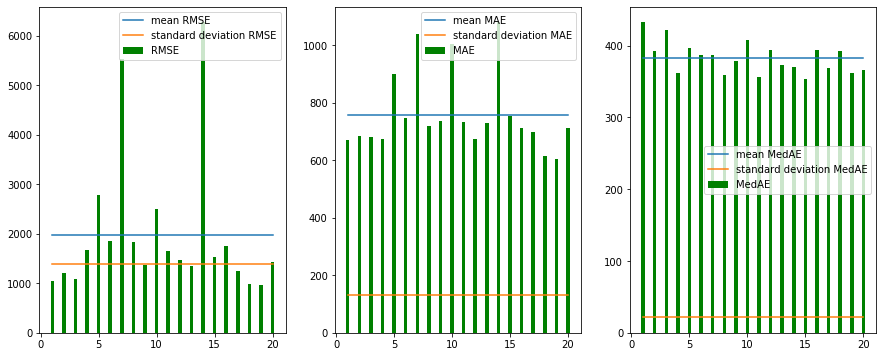

In [77]:
fi, ax= plt.subplots(1,3, figsize=(15,6))
kfold(LinearRegression(), xtrain, ytrain, 20, metrics_name="RMSE", ax=ax[0])
kfold(LinearRegression(), xtrain, ytrain, 20, metrics_name="MAE", ax=ax[1])
kfold(LinearRegression(), xtrain, ytrain, 20, metrics_name="MedAE", ax=ax[2])

The model seems to perform globally poorly and does not seem to be stable over the folders regarding the RMSE(root mean squared error) and the MAE(mean absolute error) because the mean RMSE and MAE are quite high compared to the mean production and the standard deviation of the production.

### Learning curve

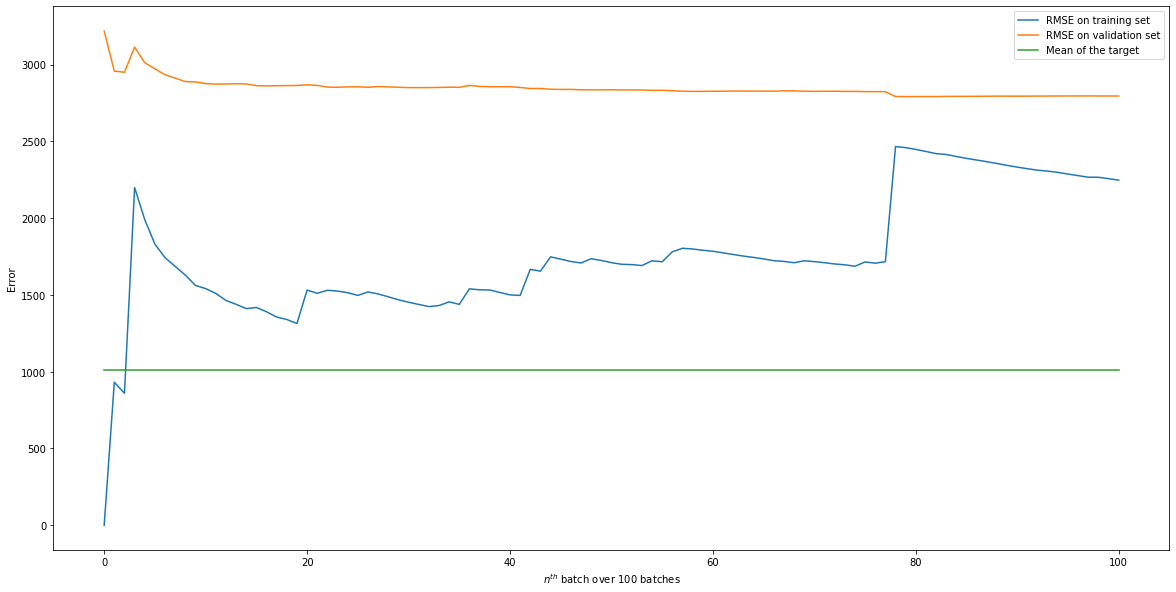

In [73]:
plot_learning_curve(LinearRegression(), xtrain, ytrain, rand_state=3)

When the amount of data is small (< 5 batches), the model seems to overfit the data, because it performs quite well on the training set but does poorly on the test set. However when the amount of data rises then the error spread shrinks, that is at least the stylized evolution we expected. When we change the seed of the randomness generator that helps splitting the data, the evolution is not exactly the same anymore, with some jumps of the training error going beyond the test error at the some points.

The model seems to underfit because the training and validation errors are relatively close to, say, the mean of the target variable (in green line) (but the learning curve may vary). We will complexify the model, hoping for a better performance.

## Polynomial regression